In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
connection = sqlite3.connect("./databases/takeaway.db")
cursor = connection.cursor()

In [3]:
print(connection)

In [4]:
def get_values(query, column_name):
    return pd.read_sql_query(query, connection)[column_name]

## 1. What is the price distribution of menu items?

In [5]:
values = get_values("SELECT price FROM menuItems",  "price")

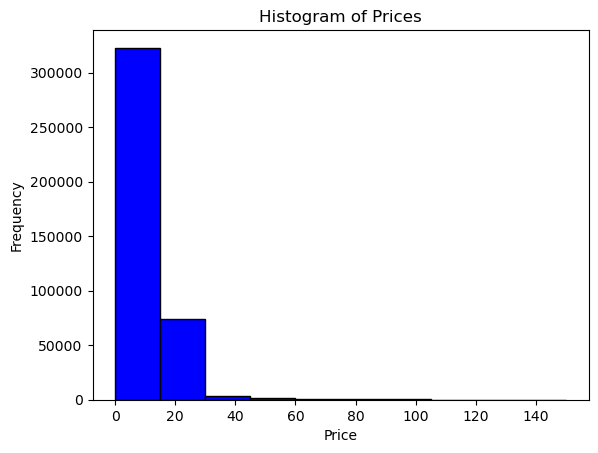

In [6]:
# Plot a histogram
plt.hist(values, bins=10, color='blue', edgecolor='black')  # Adjust 'bins' as needed
plt.title('Histogram of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
# Show the plot
plt.show()

# 2. What is the distribution of restaurants per location?

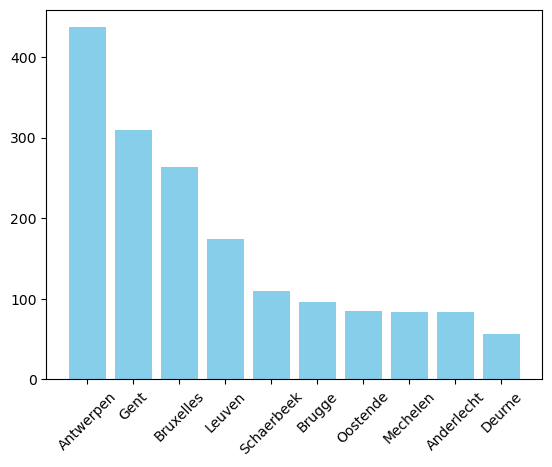

In [7]:
query = """
SELECT city, COUNT(*) 
AS RestaurantCount 
FROM restaurants 
GROUP BY city
ORDER BY RestaurantCount DESC
"""
data = pd.read_sql_query(query, connection).iloc[:10]
plt.bar(data['city'], data['RestaurantCount'], color='skyblue')
plt.xticks(rotation=45)
plt.show()

# 3. Which are the top 10 pizza restaurants by rating?

In [8]:
query = """
SELECT r.name, r.city, AVG(r.ratings) AS rating
FROM restaurants AS r
JOIN categories AS c ON c.restaurant_id = r.primarySlug
WHERE c.name LIKE '%pizza%'
GROUP BY r.name
ORDER BY rating DESC
LIMIT 10
"""

data = pd.read_sql_query(query, connection)
print(data)

                      name                  city  rating
0   Trend Kebab & Pizzeria               Maaseik     5.0
1                 Snack-It              Turnhout     5.0
2           Munchies Ieper                 Ieper     5.0
3     La Trinacria Bottega  Woluwe-Saint-Lambert     5.0
4    Kebap - Pizza De Brug               Hasselt     5.0
5  De Echte Eethuis Carlos              Aarschot     5.0
6     Pizzeria Kebap Selin             Zoutleeuw     4.9
7             Pizza L'Esta               Hoboken     4.9
8           Pitta de Kroon                 Aalst     4.9
9          Pink Pizza Genk                  Genk     4.9


## 4. Map locations offering kapsalons and their average price.

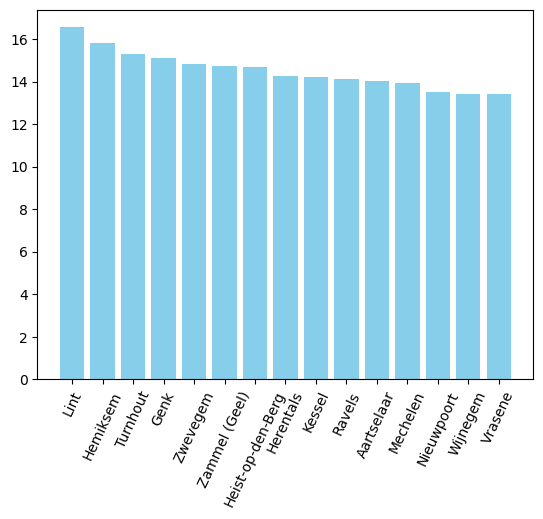

In [9]:
query = """
SELECT r.name, r.city, c.name AS category, m.name, AVG(m.price) AS price
FROM restaurants r
JOIN menuItems m ON r.primarySlug = m.primarySlug
JOIN categories c ON r.primarySlug = c.restaurant_id
WHERE c.name LIKE '%kapsalon%'
GROUP BY r.name
ORDER BY price DESC
"""

data = pd.read_sql_query(query, connection).iloc[:15]
plt.bar(data['city'], data['price'], color='skyblue')
plt.xticks(rotation=65)
plt.show()

## 5. Find the furthest point in Flanders from a bottle of Coke, using geospatial data.

In [10]:
codes_flanders = [code for code in range(2000, 3000)] + [code for code in range(9000, 10000)]\
                        + [code for code in range(1500, 2000)] + [code for code in range(3000, 4000)]\
                        + [code for code in range(8000, 9000)]

In [11]:
query = """
SELECT r.name, r.city, (r.longitude + r.latitude) AS distance
FROM restaurants AS r
JOIN menuItems m ON m.primarySlug = r.primarySlug
JOIN locations_to_restaurants loc ON loc.restaurant_id = r.primarySlug
JOIN locations l ON l.ID = loc.location_id
WHERE m.name LIKE '%coke%'
GROUP BY r.name
ORDER BY distance DESC
"""

data = pd.read_sql_query(query, connection)
print(data)

                      name         city   distance
0         Euro Kebab-Pizza   Opglabbeek  56.560060
1  Frituur-Grillroom Dalia      Lanaken  56.478416
2    Okinawa Sushi & Grill  Grobbendonk  55.926314
3              Esaki Sushi    Antwerpen  55.618612
4              Ocean Sushi    Antwerpen  55.606005
5                   Almina      Hoboken  55.537285
6       Ottoman Grillhouse         Gent  54.781711
7       Destiny Asian-Food         Gent  54.775758
8           Munchies Ieper        Ieper  53.735805


## 6. Create a Venn diagram comparing restaurant distributions across Uber Eats, Deliveroo, and Takeaway. Discuss trends.

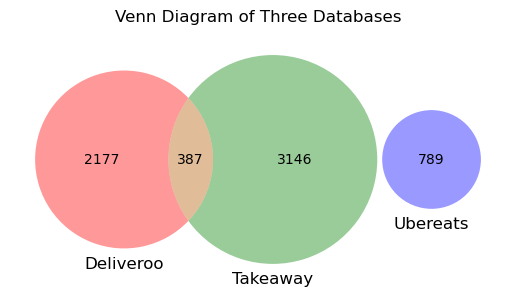

In [22]:
from matplotlib_venn import venn3
# Connect to the databases
conn1 = sqlite3.connect("./databases/deliveroo.db")
conn2 = sqlite3.connect("./databases/takeaway.db")
conn3 = sqlite3.connect("./databases/ubereats.db")
# Create cursors
cur1 = conn1.cursor()
cur2 = conn2.cursor()
cur3 = conn3.cursor()

table_name = "restaurants"
# Query unique IDs from each database
cur1.execute("SELECT DISTINCT name FROM restaurants")
ids1 = set(row[0] for row in cur1.fetchall())
cur2.execute("SELECT DISTINCT name FROM restaurants")
ids2 = set(row[0] for row in cur2.fetchall())
cur3.execute("""
SELECT DISTINCT loc.name 
FROM restaurants r 
JOIN locations_to_restaurants ltr ON ltr.restaurant_id = r.id 
JOIN locations loc ON loc.id = ltr.location_id
""")
ids3 = set(row[0] for row in cur3.fetchall())

# Unique to each database
only_in_1 = ids1 - ids2 - ids3
only_in_2 = ids2 - ids1 - ids3
only_in_3 = ids3 - ids1 - ids2
# Pairwise overlaps
in_1_and_2 = (ids1 & ids2) - ids3
in_1_and_3 = (ids1 & ids3) - ids2
in_2_and_3 = (ids2 & ids3) - ids1
# Overlap in all three
in_all = ids1 & ids2 & ids3

# Sizes for the Venn diagram
venn = venn3(
    subsets=(
        len(only_in_1),      # Unique to DB1
        len(only_in_2),      # Unique to DB2
        len(in_1_and_2),     # Shared by DB1 and DB2
        len(only_in_3),      # Unique to DB3
        len(in_1_and_3),     # Shared by DB1 and DB3
        len(in_2_and_3),     # Shared by DB2 and DB3
        len(in_all)          # Shared by all three
    ),
    set_labels=("Deliveroo", "Takeaway", "Ubereats")
)

# Customize the plot
plt.title("Venn Diagram of Three Databases")
plt.show()

## 7. How do delivery fees vary across platforms and locations?

In [ ]:
query = """
SELECT r.name, r.city, AVG(r.deliveryFee) AS Fee
FROM restaurants r
GROUP BY r.city
ORDER BY Fee DESC
"""

data = pd.read_sql_query(query, connection).iloc[:15]
plt.bar(data['city'], data['Fee'], color='skyblue')
plt.xticks(rotation=65)
plt.show()